<a href="https://colab.research.google.com/github/yung540825/NVIDIA_corp_prediction/blob/main/%E3%80%8CNVIDIA_corp_prediction(LSTM)%E7%89%88%E6%9C%AC)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#讀取csv，2016 到 2020
df = pd.read_csv('/content/NVDA (2016-2020).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,8.072500,8.145000,8.010000,8.092500,7.901622,35807600
1,2016-01-05,8.245000,8.360000,8.125000,8.222500,8.028558,49027200
2,2016-01-06,8.087500,8.125000,7.790000,7.882500,7.696577,44934400
3,2016-01-07,7.685000,7.737500,7.470000,7.570000,7.391446,64530400
4,2016-01-08,7.667500,7.675000,7.392500,7.407500,7.232779,39847200
...,...,...,...,...,...,...,...
1253,2020-12-23,132.559998,132.750000,130.050003,130.092499,129.822052,17914400
1254,2020-12-24,130.372498,131.324997,129.387497,129.937500,129.667389,9788400
1255,2020-12-28,130.625000,130.625000,127.632500,129.000000,128.731842,21256400
1256,2020-12-29,129.250000,130.725006,128.422501,129.432495,129.163437,17037200


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [ ]:
#建立新的DataFrame，包含日期和Adjusted Close(調整後收盤價)
new_df=df.iloc[:,[0,5]].copy()
new_df.head()

,Date,Adj Close
0,2016-01-04,7.901622
1,2016-01-05,8.028558
2,2016-01-06,7.696577
3,2016-01-07,7.391446
4,2016-01-08,7.232779


In [ ]:
#看Adjusted Close的敘述統計
new_df.describe()

,Adj Close
count,1258.000000
mean,49.942683
std,31.870668
min,6.156285
25%,26.710638
50%,44.726345
75%,61.575303
max,145.274368


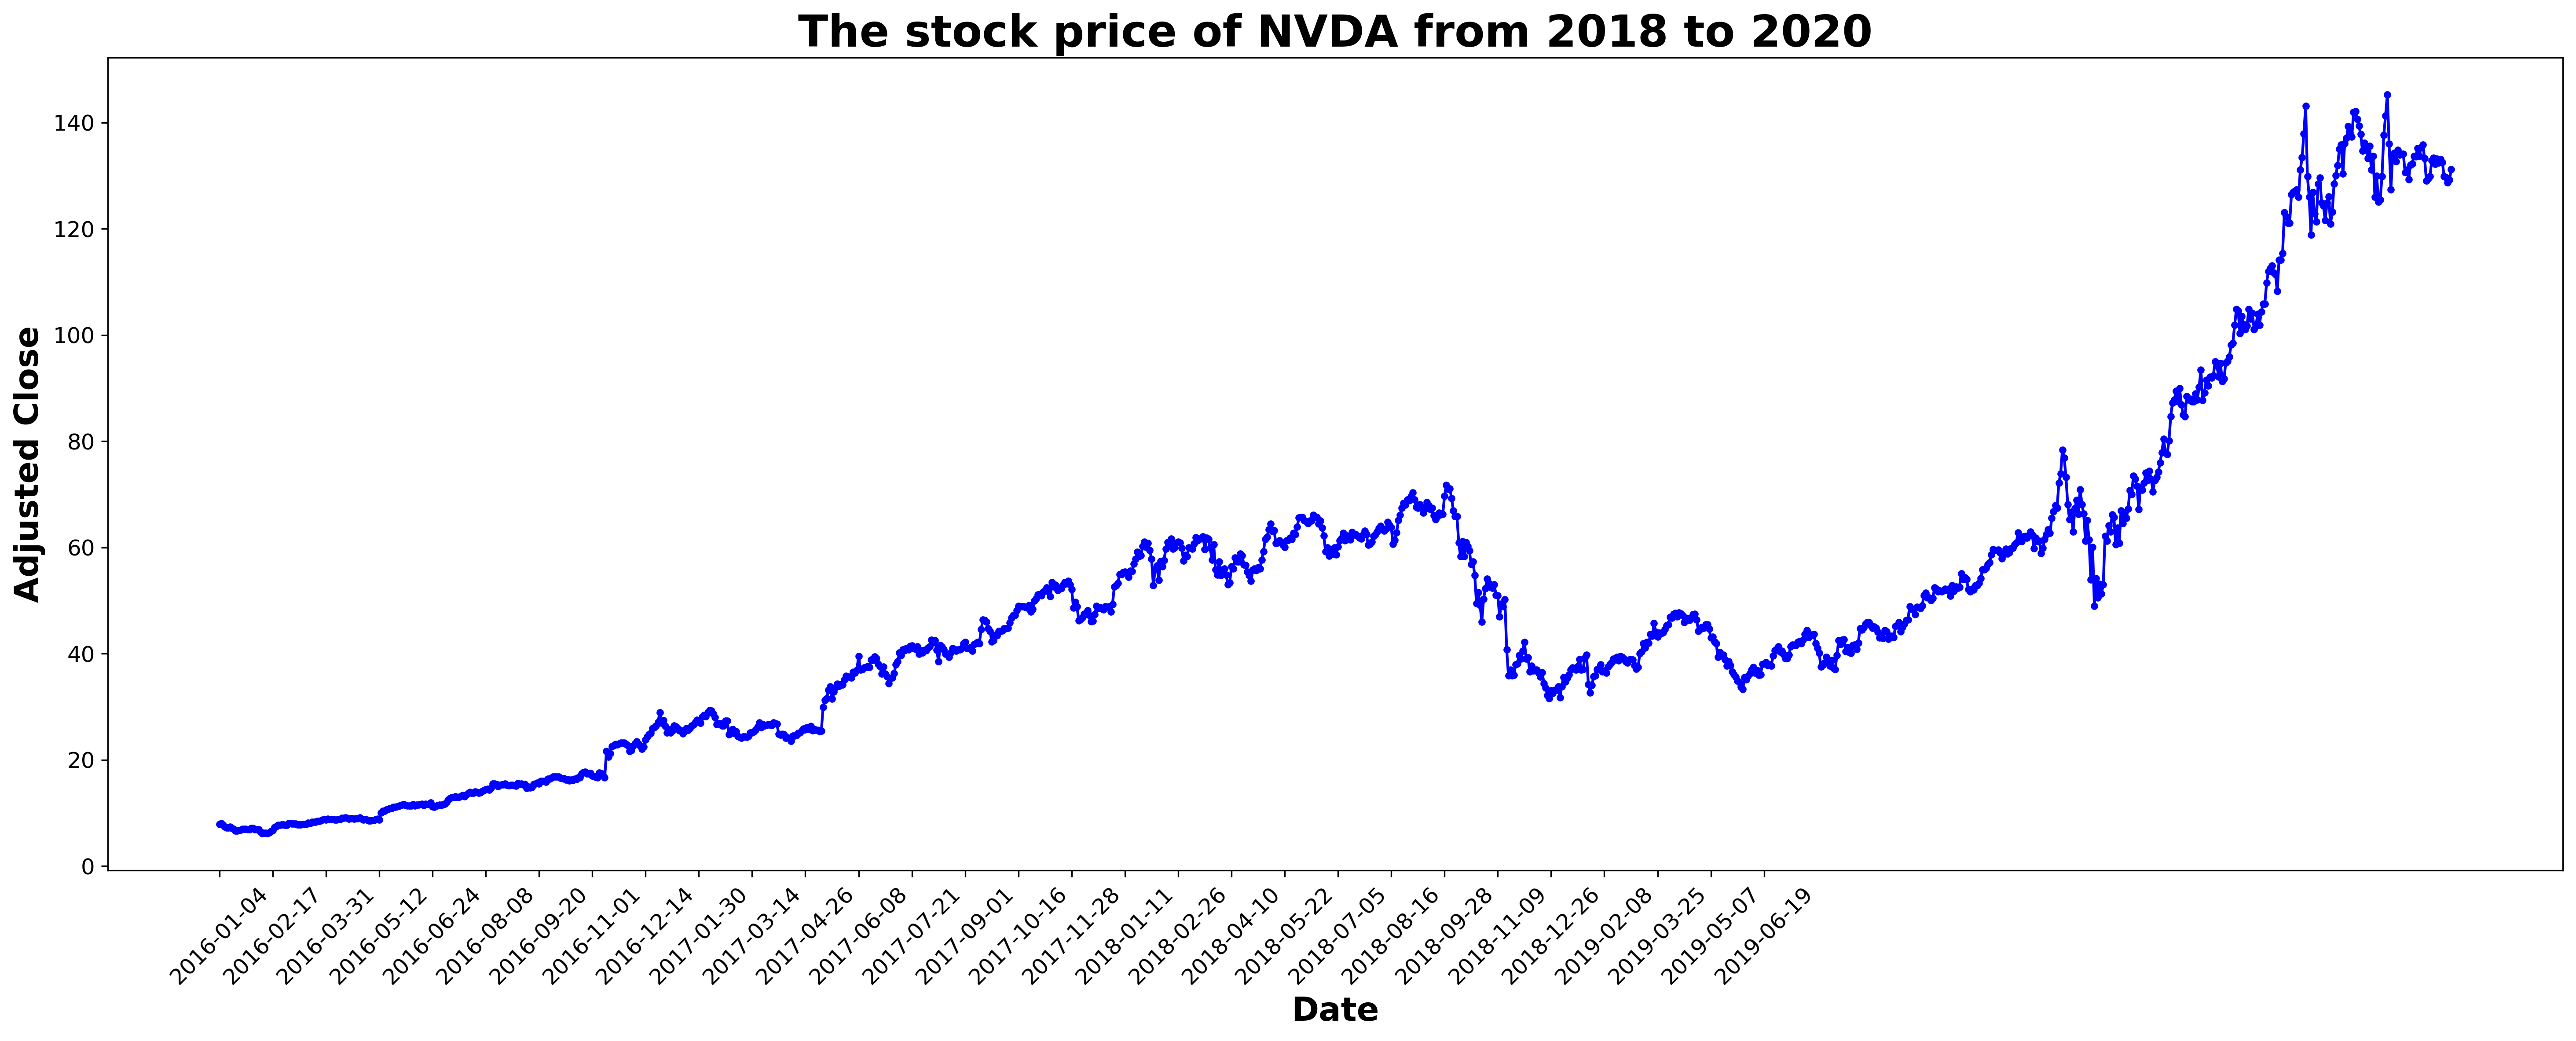

In [ ]:
#畫出2016至2020間NVDA的股價
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('The stock price of NVDA from 2018 to 2020',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Adjusted Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Adj Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 900, step=30))
plt.show()

# 2. Creating time lags as predictor variables

In [ ]:
#創建3個lags
new_df['Lag_1']=new_df['Adj Close'].shift(1).copy()#把資料往下移1格作為lag1
new_df['Lag_2']=new_df['Adj Close'].shift(2).copy()#把資料往下移1格作為lag2
new_df['Lag_3']=new_df['Adj Close'].shift(3).copy()#把資料往下移1格作為lag3
new_df.head()

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2016-01-04,7.901622,NaN,NaN,NaN
1,2016-01-05,8.028558,7.901622,NaN,NaN
2,2016-01-06,7.696577,8.028558,7.901622,NaN
3,2016-01-07,7.391446,7.696577,8.028558,7.901622
4,2016-01-08,7.232779,7.391446,7.696577,8.028558


In [ ]:
# 去除掉具NaN值的列，只有1255筆，因為lag取3
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2016-01-07,7.391446,7.696577,8.028558,7.901622
1,2016-01-08,7.232779,7.391446,7.696577,8.028558
2,2016-01-11,7.244985,7.232779,7.391446,7.696577
3,2016-01-12,7.367036,7.244985,7.232779,7.391446
4,2016-01-13,7.142461,7.367036,7.244985,7.232779
...,...,...,...,...,...
1250,2020-12-23,129.822052,132.506470,133.045319,132.444077
1251,2020-12-24,129.667389,129.822052,132.506470,133.045319
1252,2020-12-28,128.731842,129.667389,129.822052,132.506470
1253,2020-12-29,129.163437,128.731842,129.667389,129.822052


# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [ ]:
#2018到2020的資料作為訓練集
Forecast_train_data=clean_df.iloc[0:753,:].copy()
Forecast_train_data

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2016-01-07,7.391446,7.696577,8.028558,7.901622
1,2016-01-08,7.232779,7.391446,7.696577,8.028558
2,2016-01-11,7.244985,7.232779,7.391446,7.696577
3,2016-01-12,7.367036,7.244985,7.232779,7.391446
4,2016-01-13,7.142461,7.367036,7.244985,7.232779
...,...,...,...,...,...
748,2018-12-27,32.543327,33.022152,31.528593,32.146362
749,2018-12-28,33.158615,32.543327,33.022152,31.528593
750,2018-12-31,33.121395,33.158615,32.543327,33.022152
751,2019-01-02,33.796230,33.121395,33.158615,32.543327


In [ ]:
#2022年作為測試集(假日和特殊節日休市，故2022年下半年只有148筆)
Forecast_test_data=clean_df.iloc[753:753+502,:].copy()
Forecast_test_data

,Date,Adj Close,Lag_1,Lag_2,Lag_3
753,2019-01-04,33.788788,31.754366,33.796230,33.121395
754,2019-01-07,35.577599,33.788788,31.754366,33.796230
755,2019-01-08,34.691875,35.577599,33.788788,31.754366
756,2019-01-09,35.374153,34.691875,35.577599,33.788788
757,2019-01-10,36.031609,35.374153,34.691875,35.577599
...,...,...,...,...,...
1250,2020-12-23,129.822052,132.506470,133.045319,132.444077
1251,2020-12-24,129.667389,129.822052,132.506470,133.045319
1252,2020-12-28,128.731842,129.667389,129.822052,132.506470
1253,2020-12-29,129.163437,128.731842,129.667389,129.822052


# 4. Prepare time-series data for train/validation structure manually

# Expanding window

In [ ]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:660,:].copy()
Exp_val_1=Forecast_train_data.iloc[660:660+30,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:690,:].copy()
Exp_val_2=Forecast_train_data.iloc[690:690+30,:].copy()

# Expanding 3:
Exp_training_3=Forecast_train_data.iloc[0:723,:].copy()
Exp_val_3=Forecast_train_data.iloc[723:723+30,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X)

In [ ]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Adj Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Adj Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Adj Close'].copy()
y_val=Exp_val_3['Adj Close'].copy()

# 6. Creating Net

In [ ]:
# Quick recap: 有3個feature在data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.023494,0.028557,0.026621
1,0.018840,0.023494,0.028557
2,0.016419,0.018840,0.023494
3,0.016606,0.016419,0.018840
4,0.018467,0.016606,0.016419


In [ ]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [ ]:
import keras.backend as K
from keras.losses import mse
from keras.utils import get_custom_objects

def my_RMSE(y_true, y_pred):
    return K.sqrt(mse(y_true, y_pred))

get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.

# Sequential style coding for creating net

In [ ]:
x_train.shape[1]#輸入的feature=3

3

In [ ]:
keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1))) #input_shape=(lag數,每個lag要測量的特徵數)
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

opt = Adam(learning_rate=0.01, beta_1=0.9)#@
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


問題
1.LSTM、GRU也可以用model.add(BatchNormalization())嗎
2.validation loss降不下來要怎麼辦，是要增加dropout嗎

# 7. Fit the model (train/validation)

In [ ]:

# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=100, batch_size=128,verbose=1,validation_data=(scaled_x_val, y_val))#@

Epoch 1/100
6/6 [==============================] - 15s 452ms/step - loss: 1662.6178 - mean_absolute_percentage_error: 98.2751 - val_loss: 994.0889 - val_mean_absolute_percentage_error: 87.3875
Epoch 2/100
6/6 [==============================] - 0s 58ms/step - loss: 680.6636 - mean_absolute_percentage_error: 71.9168 - val_loss: 410.7155 - val_mean_absolute_percentage_error: 54.7344
Epoch 3/100
6/6 [==============================] - 0s 74ms/step - loss: 335.6123 - mean_absolute_percentage_error: 90.0500 - val_loss: 63.3578 - val_mean_absolute_percentage_error: 21.2074
Epoch 4/100
6/6 [==============================] - 0s 78ms/step - loss: 272.4680 - mean_absolute_percentage_error: 44.8514 - val_loss: 35.2474 - val_mean_absolute_percentage_error: 12.5202
Epoch 5/100
6/6 [==============================] - 1s 95ms/step - loss: 112.2621 - mean_absolute_percentage_error: 41.9522 - val_loss: 219.6325 - val_mean_absolute_percentage_error: 36.4632
Epoch 6/100
6/6 [==============================] 

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

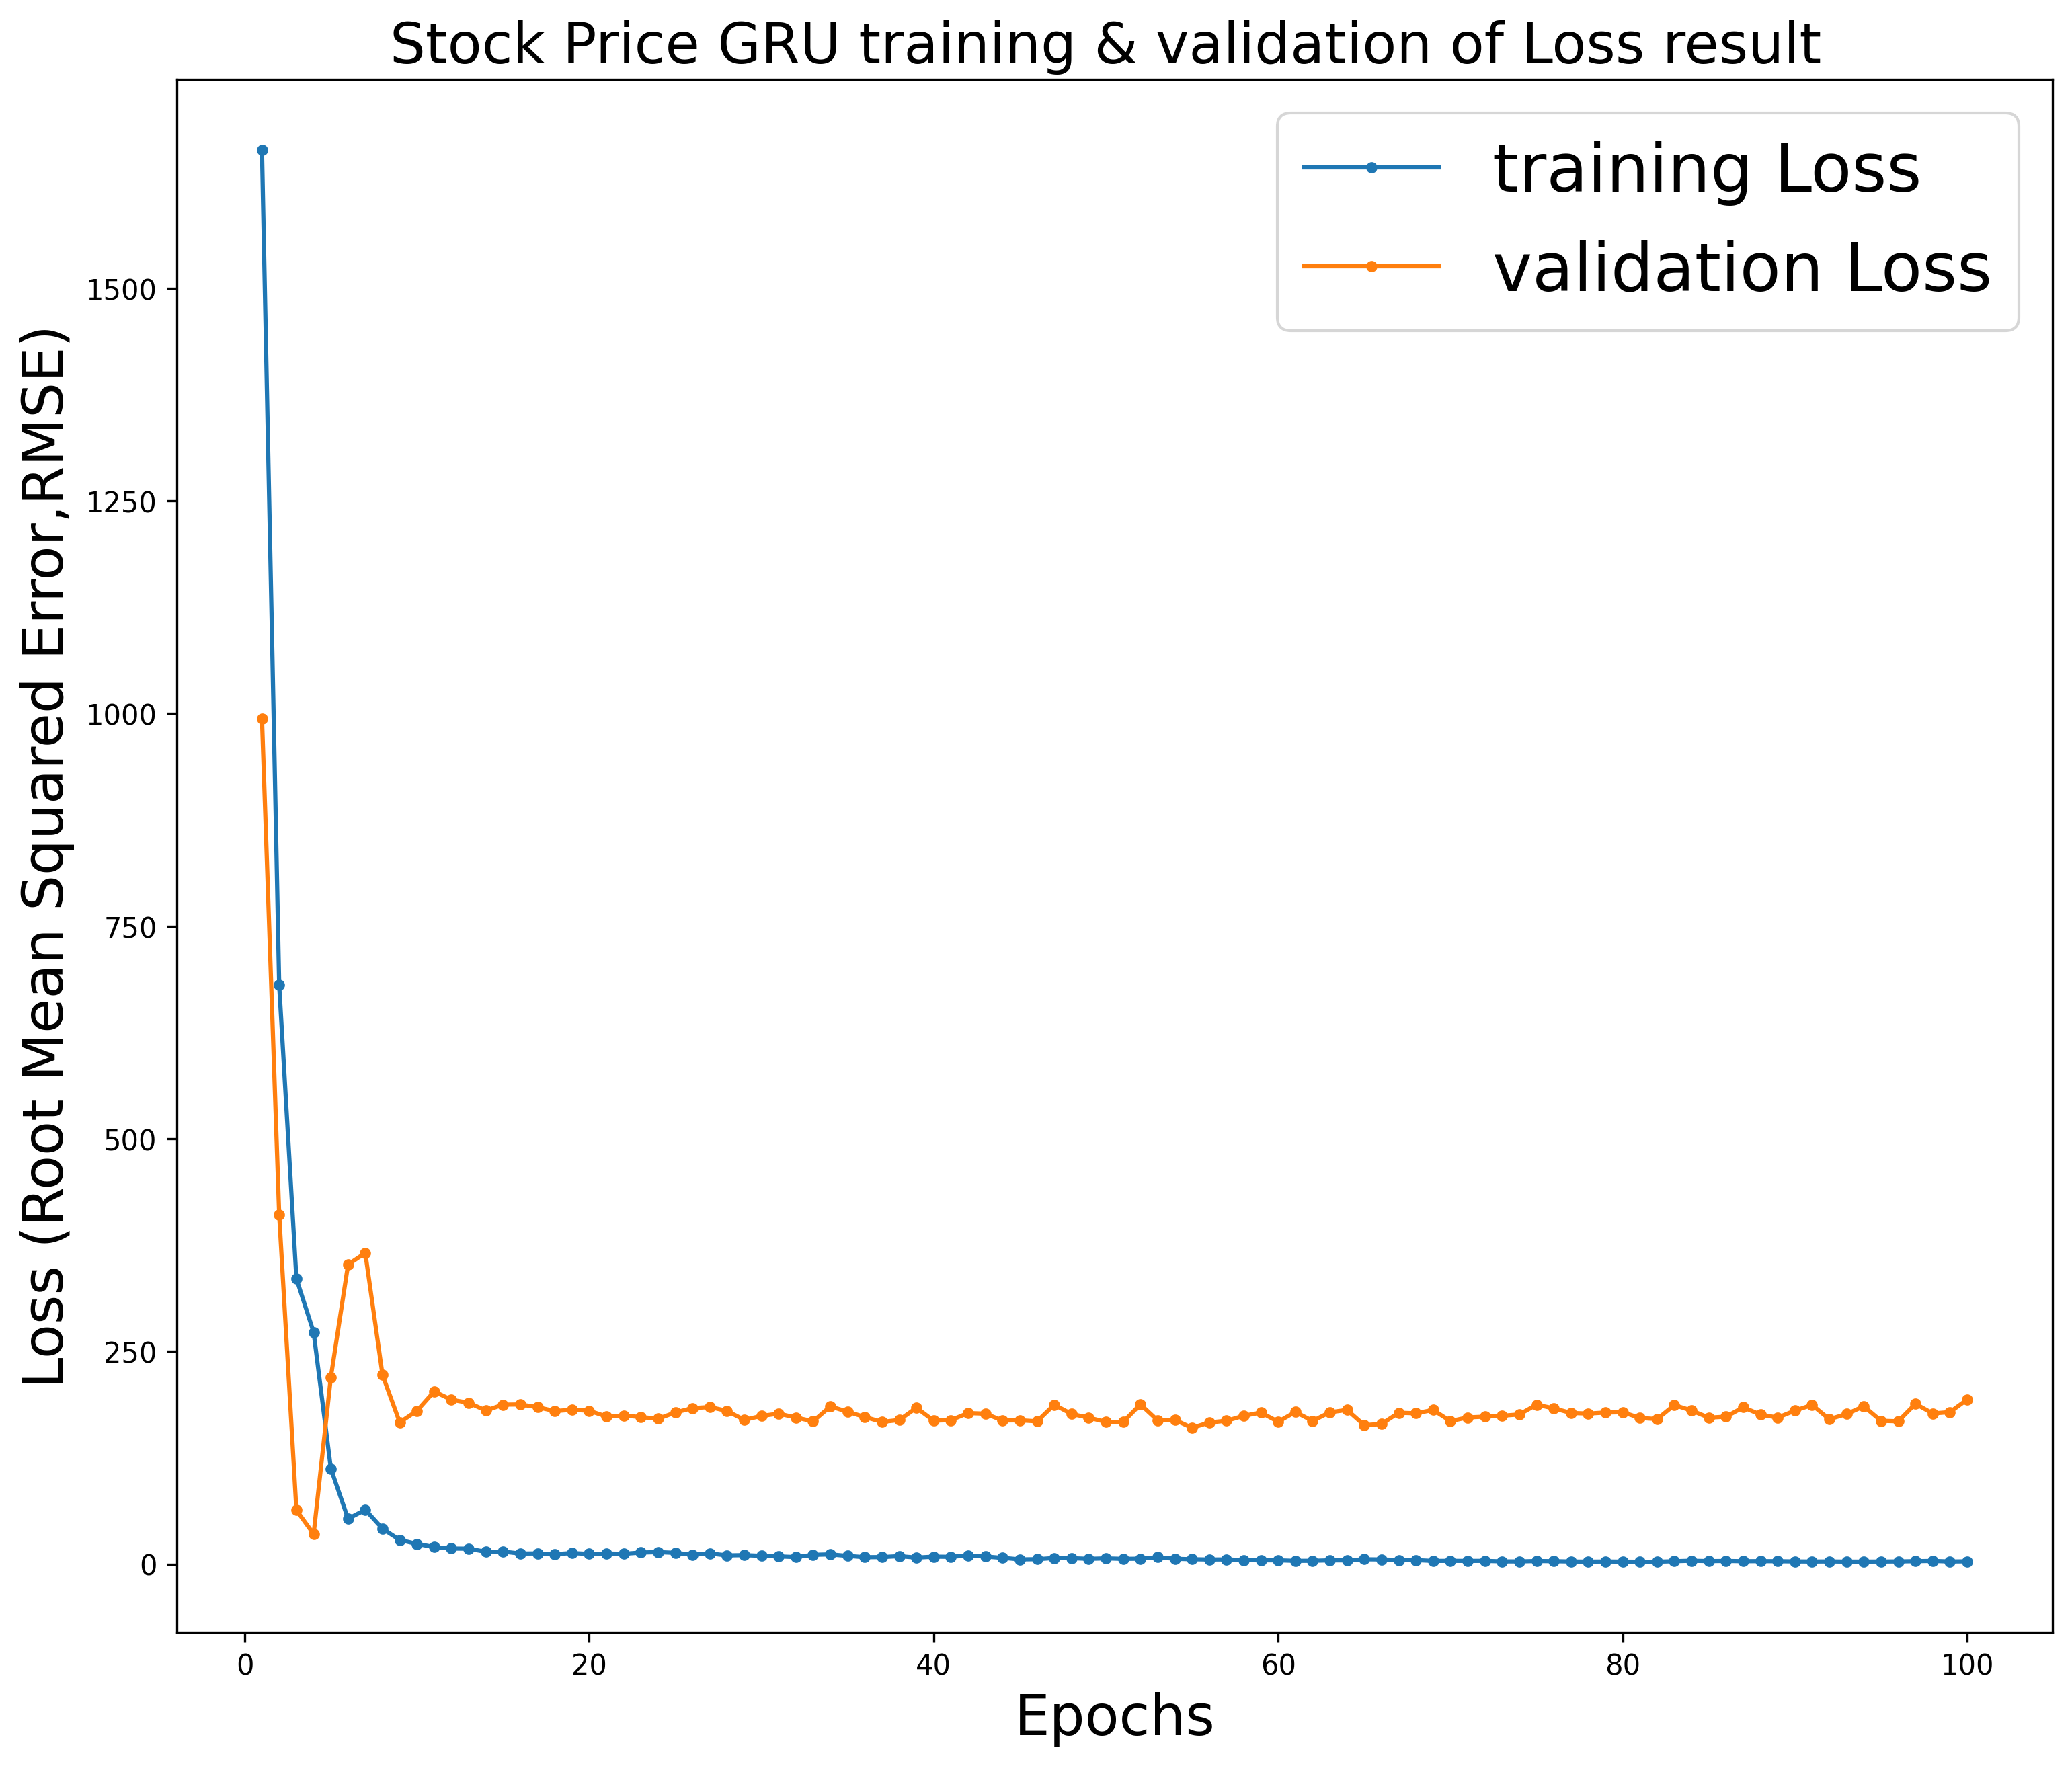

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Stock Price GRU training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

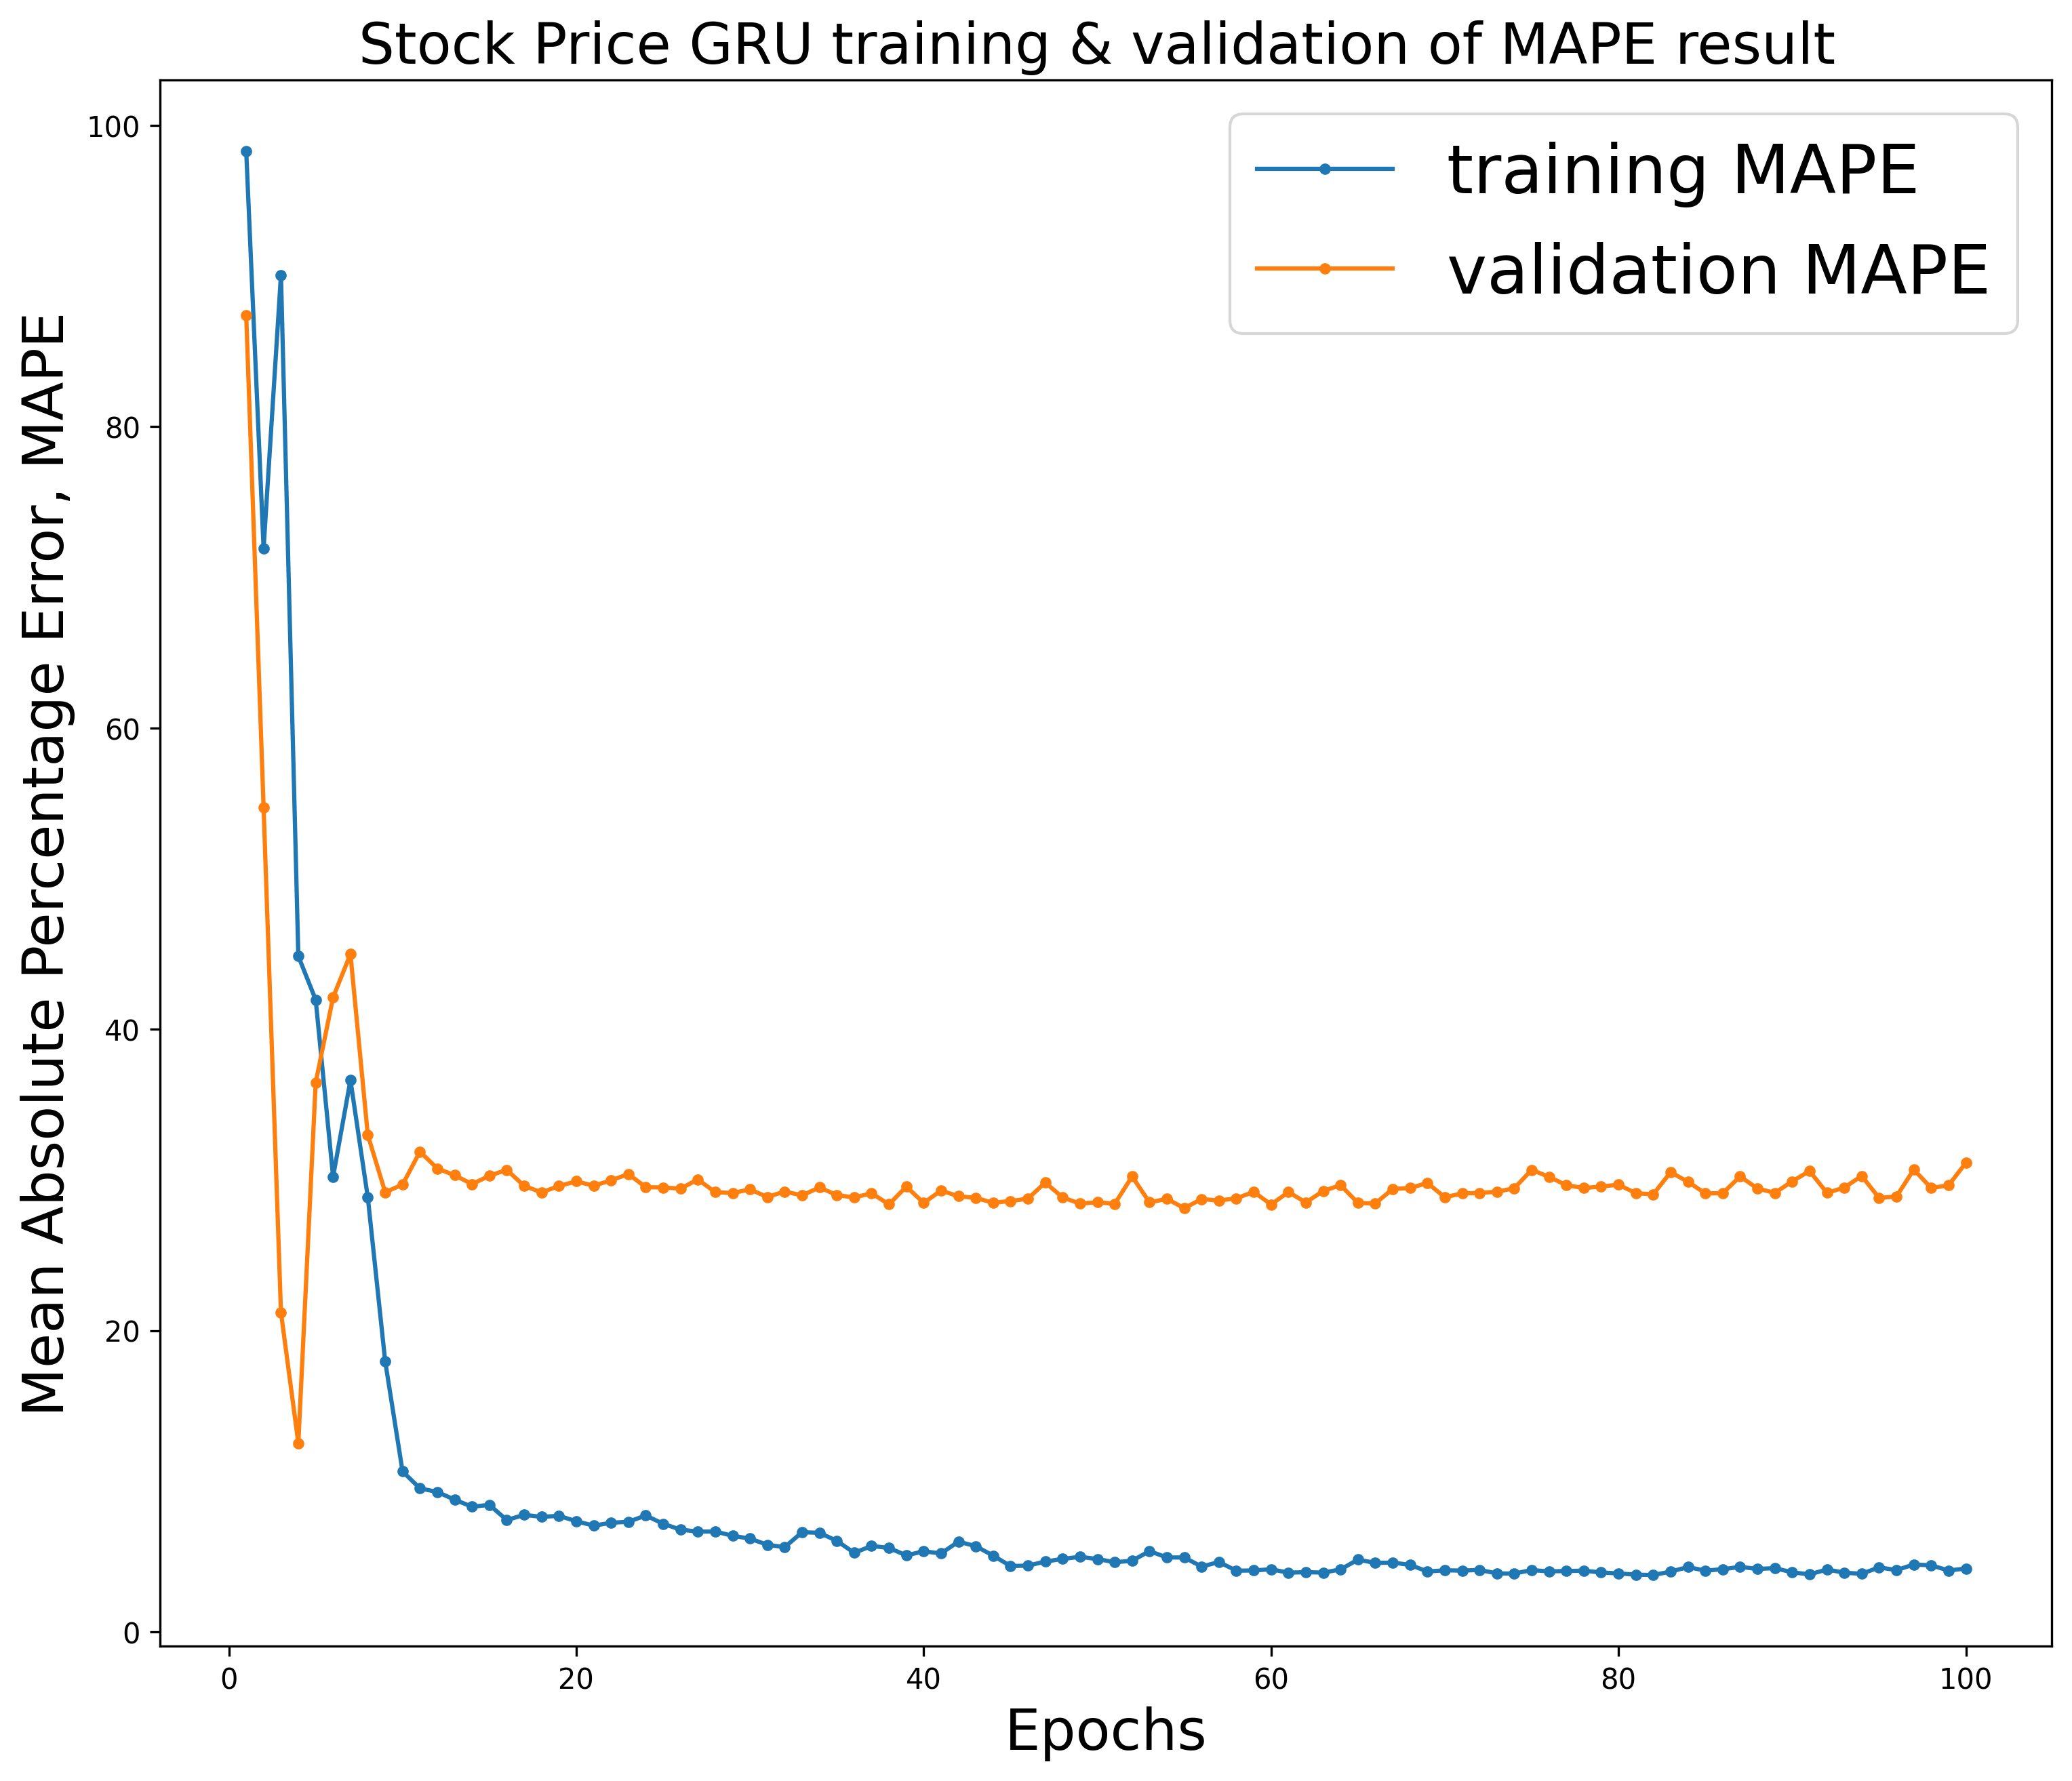

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Stock Price GRU training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Adj Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Adj Close'].copy()

In [ ]:
keras.backend.clear_session()

model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1))) #input_shape=(lag數,每個lag要測量的特徵數)
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

opt = Adam(learning_rate=0.001, beta_1=0.9)#@
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Store in the history for more useful information
history=model.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=128,verbose=1)

Epoch 1/300
6/6 [==============================] - 5s 15ms/step - loss: 1337.6494 - mean_absolute_percentage_error: 84.6685
Epoch 2/300
6/6 [==============================] - 0s 13ms/step - loss: 407.5933 - mean_absolute_percentage_error: 97.0738
Epoch 3/300
6/6 [==============================] - 0s 13ms/step - loss: 310.5392 - mean_absolute_percentage_error: 39.2589
Epoch 4/300
6/6 [==============================] - 0s 13ms/step - loss: 81.1835 - mean_absolute_percentage_error: 29.8289
Epoch 5/300
6/6 [==============================] - 0s 14ms/step - loss: 130.2624 - mean_absolute_percentage_error: 36.1463
Epoch 6/300
6/6 [==============================] - 0s 15ms/step - loss: 49.7470 - mean_absolute_percentage_error: 17.8441
Epoch 7/300
6/6 [==============================] - 0s 15ms/step - loss: 40.1585 - mean_absolute_percentage_error: 15.7156
Epoch 8/300
6/6 [==============================] - 0s 15ms/step - loss: 27.0801 - mean_absolute_percentage_error: 12.5027
Epoch 9/300
6/6 [==

In [ ]:
# 7.3 Save the trained model
model.save('D:/data_analysis/PyExport/NVIDIAcorp_prediction_model')
# Colab
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
RNN_model=keras.models.load_model('D:/data_analysis/PyExport/NVIDIAcorp_prediction_model')
# Colab
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Adj Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Adj Close'].copy()

In [ ]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 8.1 Make prediction
prediction=np.round((RNN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Adj Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
753,2019-01-04,33.788788,32.180000,1.608788
754,2019-01-07,35.577599,34.139999,1.437600
755,2019-01-08,34.691875,35.990002,1.298127
756,2019-01-09,35.374153,35.160000,0.214153
757,2019-01-10,36.031609,35.849998,0.181611
...,...,...,...,...
1250,2020-12-23,129.822052,92.000000,37.822052
1251,2020-12-24,129.667389,91.750000,37.917389
1252,2020-12-28,128.731842,91.709999,37.021843
1253,2020-12-29,129.163437,91.620003,37.543434


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)



print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 9.98
MSE: 329.652
RMSE: 18.156
MAPE: 8.937 %
SMAPE: 10.076 %
RAE: 0.334
MRAE: 0.0006657717745662451
MdRAE: 0.082 bench: 71.112
RSE: 0.274
RRSE: 0.523


#  Plot for comparing true value & predicted value

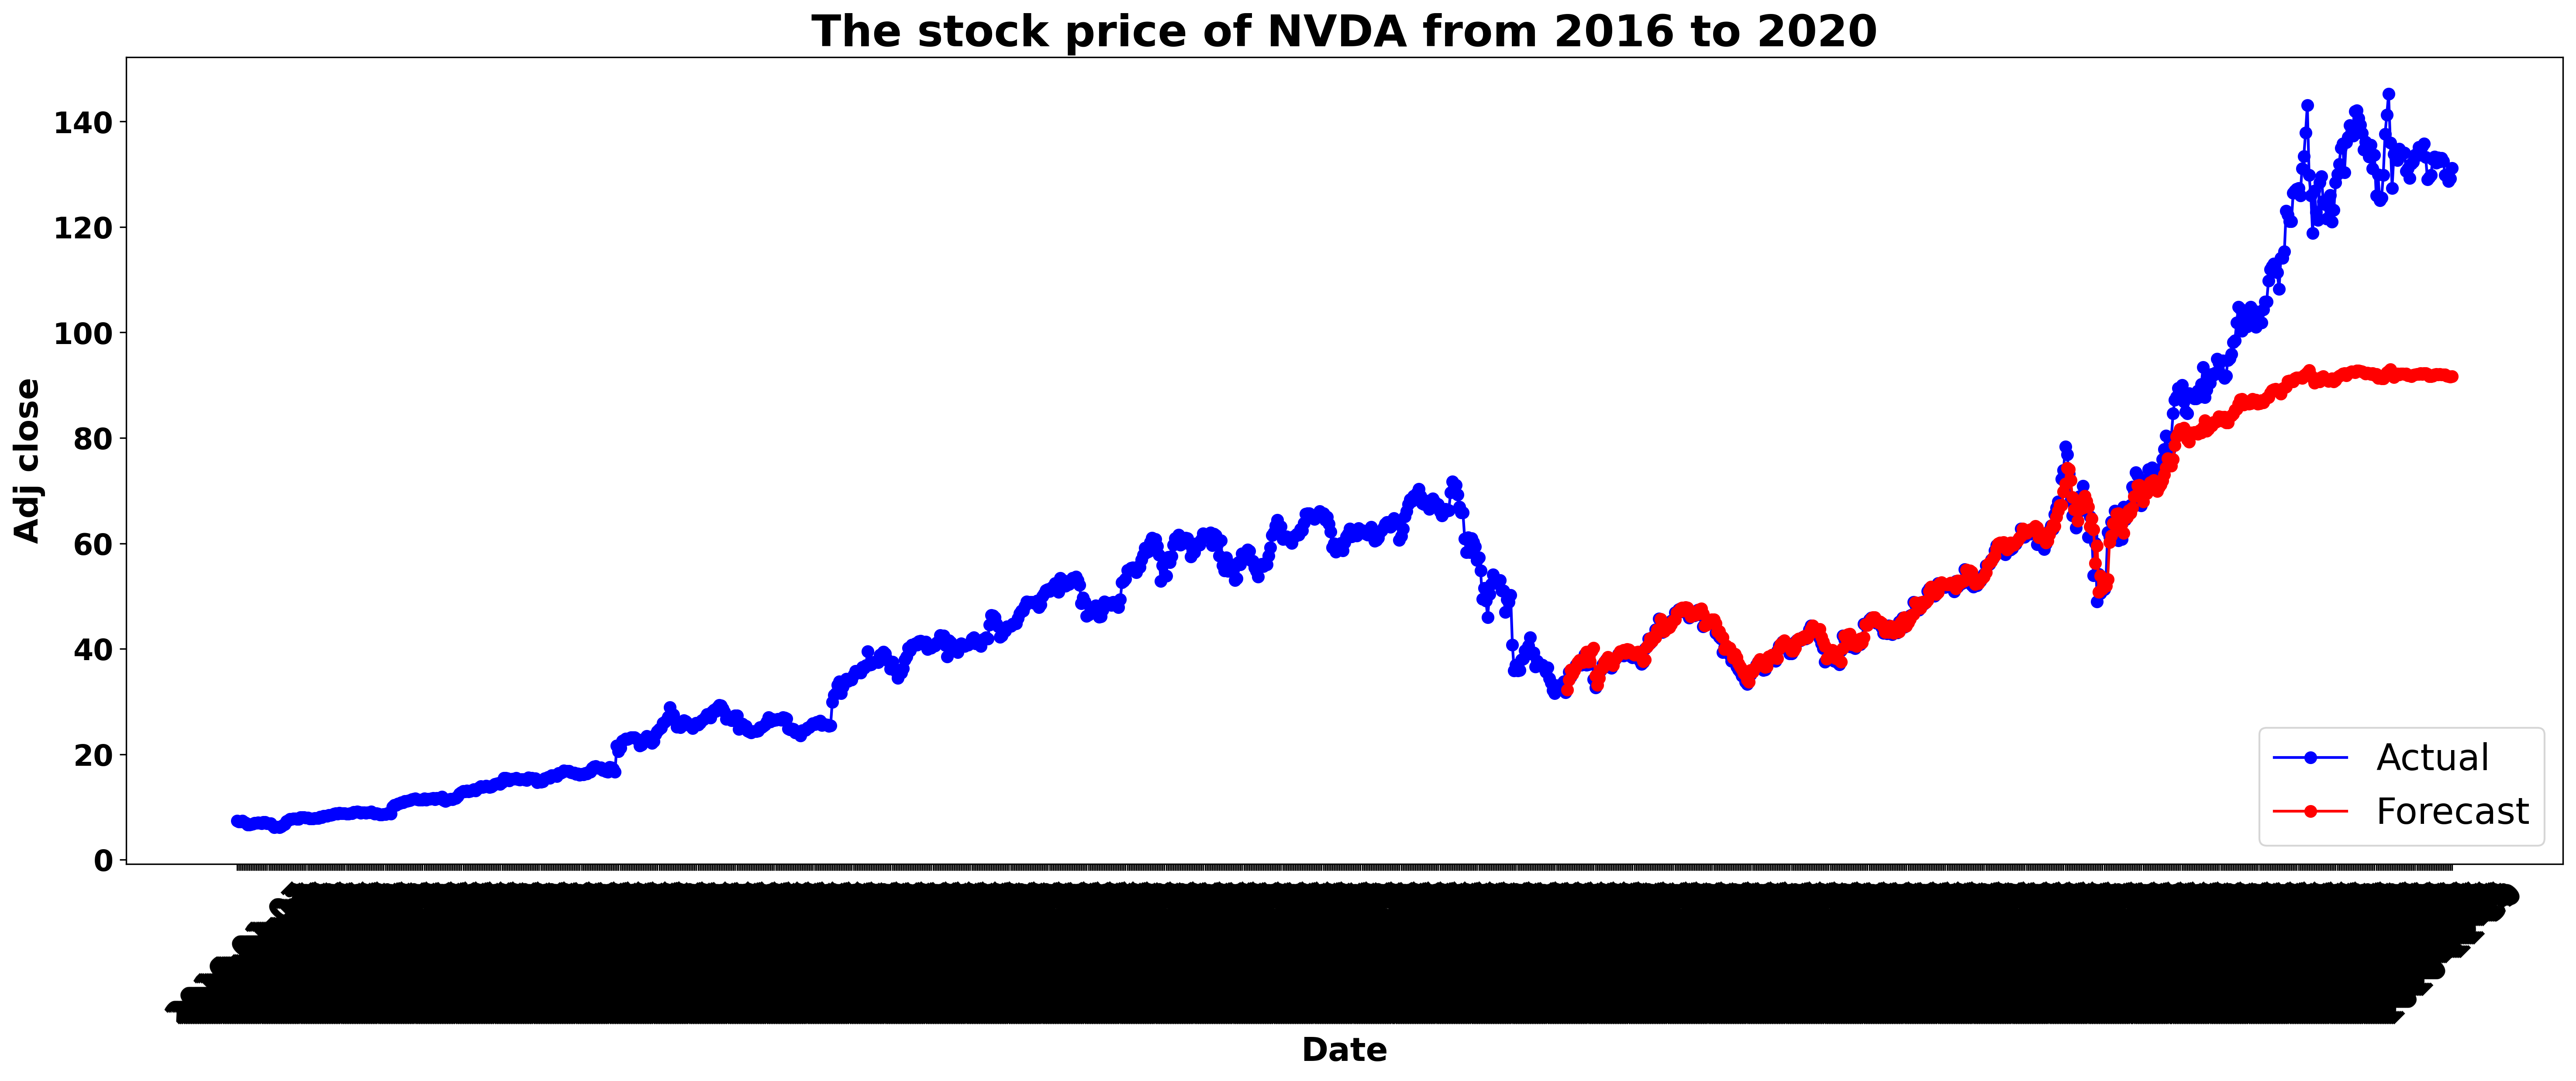

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('The stock price of NVDA from 2016 to 2020', weight='bold', fontsize=24)
plt.xlabel('Date', fontsize=18, weight='bold')
plt.ylabel('Adj close', fontsize=18, weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df['Date'], clean_df['Adj Close'], marker='o', color='blue', label='Actual')
plt.plot(Results['Date'], Results['Predict'], marker='o', color='red', label='Forecast')

# Set the axis
plt.xticks(fontsize=16, rotation=45, weight='bold')
plt.yticks(fontsize=16, weight='bold')

# Set legends
plt.legend(loc=4, fontsize=20)

plt.show()

# Actual by predicted plot

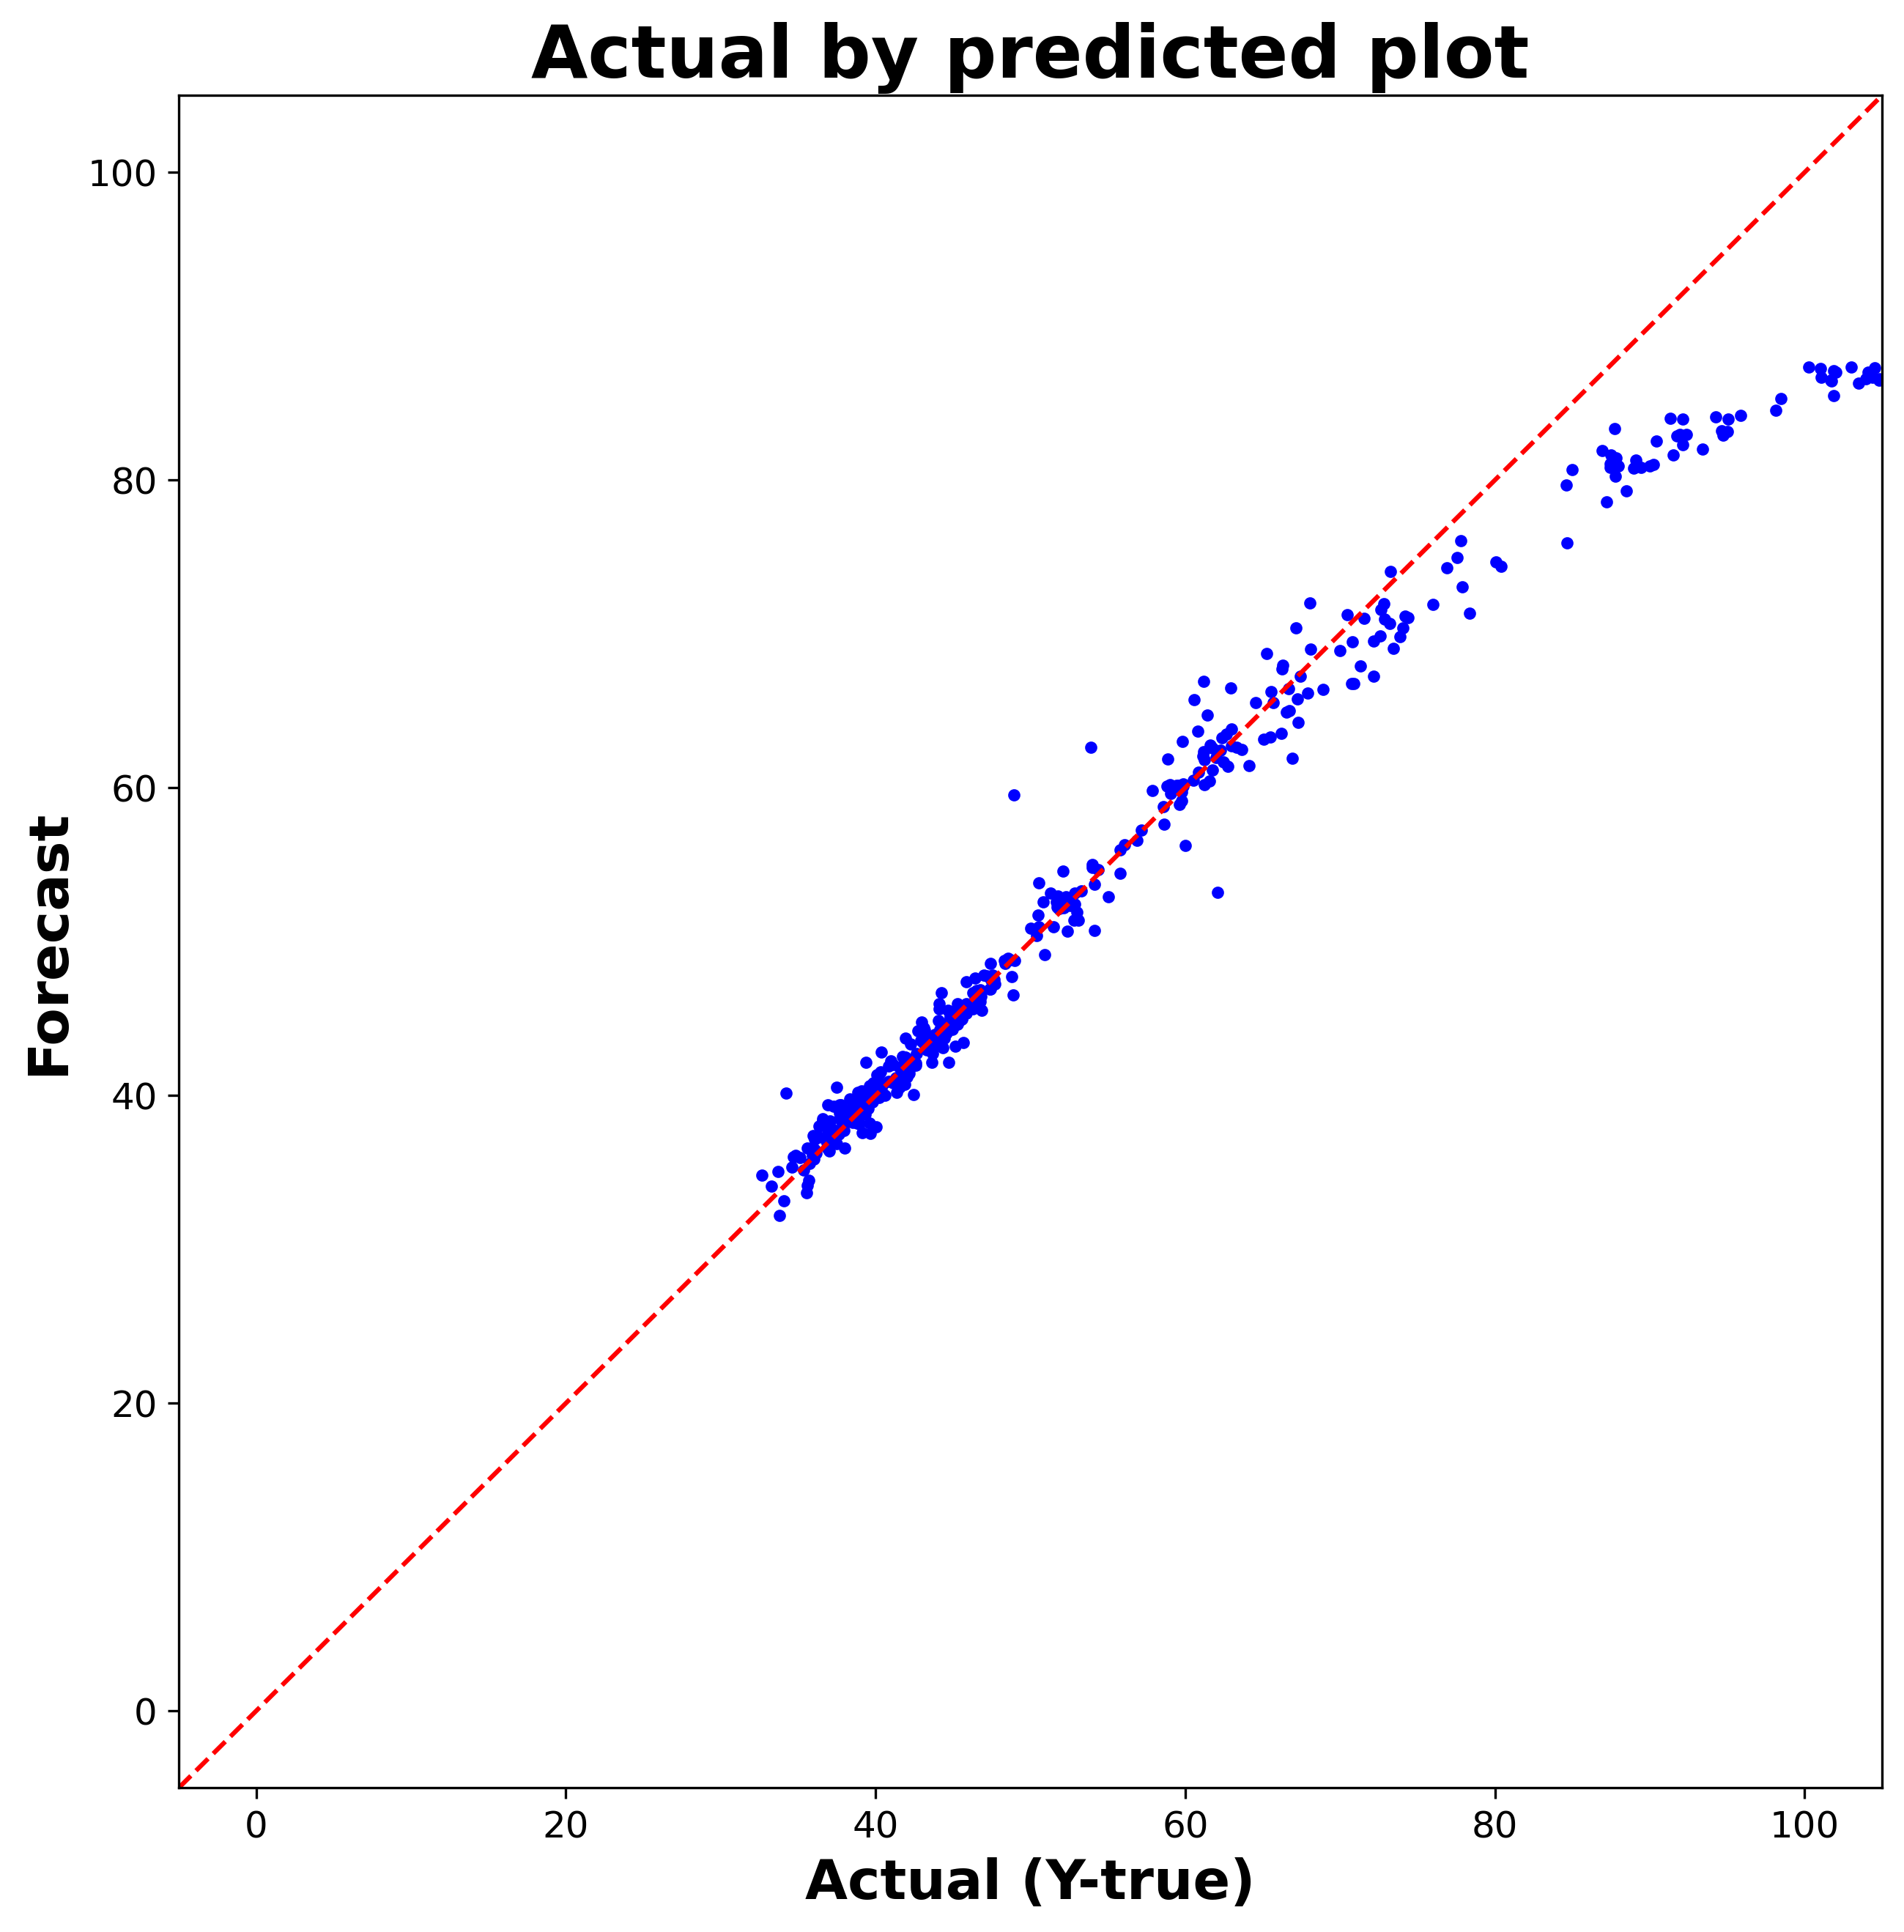

In [ ]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()